In [142]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [156]:
data = pd.read_csv('Estimated Wave parameters_Dataset_(6.5m).csv')
data.columns

Index(['Amplitude', 'Gravity (g)', 'Average Densisty(roh)', 'Pi', 'Depth (d)',
       'Period (T)', 'Wavelength (λ)', 'Wave Speed', 'Current Speed'],
      dtype='object')

In [157]:
data = data.dropna()

In [158]:
data = data[['Amplitude', 'Gravity (g)', 'Pi', 'Depth (d)', 'Wavelength (λ)', 'Current Speed']]


In [159]:
X = data[['Amplitude', 'Gravity (g)', 'Pi', 'Depth (d)', 'Wavelength (λ)']]
y = data['Current Speed']
 


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [162]:
# Convert the DataFrame to a tensor
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# Convert the DataFrames to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Ensure that X_train and X_test are 2D tensors
if len(X_train.shape) == 1:
    X_train = tf.reshape(X_train, (-1, 1))
if len(X_test.shape) == 1:
    X_test = tf.reshape(X_test, (-1, 1))


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2491, 5)
X_test shape: (1068, 5)
y_train shape: (2491,)
y_test shape: (1068,)


In [163]:
class CurrentSpeedPINN(tf.keras.Model):
    def __init__(self):
        super(CurrentSpeedPINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.bn = tf.keras.layers.BatchNormalization()
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.bn(x)
        output = self.output_layer(x)
        return output


In [169]:
# This section defines a custom loss function that includes both a physics-based loss 
#(enforcing a specific equation related to wave parameters and current speed) and a data loss (standard regression loss). 
#This combination allows the model to learn the underlying physics while fitting the data.



def physics_loss(model, X, y):
    amplitude = X[:, 0]
    gravity_g = X[:, 1]
    pi = X[:, 2]
    depth_d = X[:, 3]
    wavelength_lambda = X[:, 4]

    with tf.GradientTape(persistent=True) as tape:
        predictions = model(X)
        physics_equation = tf.sqrt((gravity_g * amplitude / (2 * pi)) * tf.tanh(2 * pi * depth_d / wavelength_lambda))
        physics_loss_value = tf.reduce_mean(tf.square(physics_equation - predictions))

        # Calculate the data loss using mean squared error
        data_loss = tf.reduce_mean(tf.square(y - predictions))

        # Calculate the total loss by combining the physics and data losses
        total_loss = physics_loss_value + data_loss

    # Compute gradients with respect to model's trainable variables
    physics_loss_gradients = tape.gradient(total_loss, model.trainable_variables)

    return physics_loss_value, data_loss, total_loss, physics_loss_gradients



In [173]:
# Initialize the model and optimizer
model = CurrentSpeedPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
epoch =1000


# Lists to store loss values
physics_losses = []
data_losses = []
total_losses = []


# Training loop
for epoch in range(1000):
    physics_loss_value, data_loss, total_loss, physics_loss_gradients = physics_loss(model, X_train, y_train)

    # Apply gradients to the model
    gradients = physics_loss_gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Append loss values to the lists
    physics_losses.append(physics_loss_value.numpy())
    data_losses.append(data_loss.numpy())
    total_losses.append(total_loss.numpy())

    print(f"Epoch {epoch + 1}, Physics Loss: {physics_loss_value.numpy()}, Data Loss: {data_loss.numpy()}, Total Loss: {total_loss.numpy()}")


Epoch 1, Physics Loss: 0.47490355372428894, Data Loss: 0.06574755907058716, Total Loss: 0.5406510829925537
Epoch 2, Physics Loss: 0.3978937268257141, Data Loss: 1.0139455795288086, Total Loss: 1.411839246749878
Epoch 3, Physics Loss: 0.08764585107564926, Data Loss: 0.3755369186401367, Total Loss: 0.4631827771663666
Epoch 4, Physics Loss: 0.18323439359664917, Data Loss: 0.011016177013516426, Total Loss: 0.19425056874752045
Epoch 5, Physics Loss: 0.512187659740448, Data Loss: 0.07947316020727158, Total Loss: 0.5916607975959778
Epoch 6, Physics Loss: 0.4993007779121399, Data Loss: 0.07447033375501633, Total Loss: 0.5737711191177368
Epoch 7, Physics Loss: 0.2553681433200836, Data Loss: 0.009914041496813297, Total Loss: 0.26528218388557434
Epoch 8, Physics Loss: 0.07703155279159546, Data Loss: 0.06942007690668106, Total Loss: 0.14645162224769592
Epoch 9, Physics Loss: 0.053970567882061005, Data Loss: 0.23953692615032196, Total Loss: 0.29350748658180237
Epoch 10, Physics Loss: 0.075365558266

Epoch 78, Physics Loss: 0.08706258237361908, Data Loss: 0.052767314016819, Total Loss: 0.13982990384101868
Epoch 79, Physics Loss: 0.09016034752130508, Data Loss: 0.04951315373182297, Total Loss: 0.13967350125312805
Epoch 80, Physics Loss: 0.09321991354227066, Data Loss: 0.046523816883563995, Total Loss: 0.13974373042583466
Epoch 81, Physics Loss: 0.0945638045668602, Data Loss: 0.04526698216795921, Total Loss: 0.1398307830095291
Epoch 82, Physics Loss: 0.09355777502059937, Data Loss: 0.04617748782038689, Total Loss: 0.13973526656627655
Epoch 83, Physics Loss: 0.09098542481660843, Data Loss: 0.04862720146775246, Total Loss: 0.13961263000965118
Epoch 84, Physics Loss: 0.08841779083013535, Data Loss: 0.05122368037700653, Total Loss: 0.13964146375656128
Epoch 85, Physics Loss: 0.08719063550233841, Data Loss: 0.05251475051045418, Total Loss: 0.13970538973808289
Epoch 86, Physics Loss: 0.08779978007078171, Data Loss: 0.05184781551361084, Total Loss: 0.13964760303497314
Epoch 87, Physics Loss

Epoch 153, Physics Loss: 0.09025540947914124, Data Loss: 0.04895675554871559, Total Loss: 0.13921216130256653
Epoch 154, Physics Loss: 0.09021022170782089, Data Loss: 0.049000222235918045, Total Loss: 0.13921044766902924
Epoch 155, Physics Loss: 0.09013805538415909, Data Loss: 0.049070876091718674, Total Loss: 0.13920892775058746
Epoch 156, Physics Loss: 0.09017007797956467, Data Loss: 0.04903719574213028, Total Loss: 0.13920727372169495
Epoch 157, Physics Loss: 0.09024839103221893, Data Loss: 0.04895743355154991, Total Loss: 0.13920582830905914
Epoch 158, Physics Loss: 0.09024850279092789, Data Loss: 0.04895578697323799, Total Loss: 0.13920429348945618
Epoch 159, Physics Loss: 0.0901920422911644, Data Loss: 0.04901083931326866, Total Loss: 0.13920287787914276
Epoch 160, Physics Loss: 0.09019828587770462, Data Loss: 0.04900311306118965, Total Loss: 0.13920140266418457
Epoch 161, Physics Loss: 0.0902237519621849, Data Loss: 0.04897632822394371, Total Loss: 0.13920007646083832
Epoch 162,

Epoch 230, Physics Loss: 0.09019236266613007, Data Loss: 0.04895924776792526, Total Loss: 0.13915160298347473
Epoch 231, Physics Loss: 0.0901898443698883, Data Loss: 0.048961300402879715, Total Loss: 0.13915114104747772
Epoch 232, Physics Loss: 0.09014816582202911, Data Loss: 0.04900258406996727, Total Loss: 0.13915075361728668
Epoch 233, Physics Loss: 0.09023281931877136, Data Loss: 0.04891755059361458, Total Loss: 0.13915036618709564
Epoch 234, Physics Loss: 0.09013326466083527, Data Loss: 0.04901652783155441, Total Loss: 0.13914978504180908
Epoch 235, Physics Loss: 0.09019041061401367, Data Loss: 0.048958875238895416, Total Loss: 0.1391492784023285
Epoch 236, Physics Loss: 0.09015016257762909, Data Loss: 0.048998650163412094, Total Loss: 0.13914881646633148
Epoch 237, Physics Loss: 0.09020411223173141, Data Loss: 0.04894426837563515, Total Loss: 0.13914838433265686
Epoch 238, Physics Loss: 0.09013748914003372, Data Loss: 0.04901054501533508, Total Loss: 0.1391480267047882
Epoch 239,

Epoch 305, Physics Loss: 0.09036606550216675, Data Loss: 0.0487697497010231, Total Loss: 0.13913580775260925
Epoch 306, Physics Loss: 0.0903390496969223, Data Loss: 0.04879647120833397, Total Loss: 0.13913552463054657
Epoch 307, Physics Loss: 0.09006340056657791, Data Loss: 0.04907179996371269, Total Loss: 0.1391351968050003
Epoch 308, Physics Loss: 0.08999533206224442, Data Loss: 0.04913991689682007, Total Loss: 0.1391352415084839
Epoch 309, Physics Loss: 0.09020046144723892, Data Loss: 0.04893434792757034, Total Loss: 0.13913480937480927
Epoch 310, Physics Loss: 0.09029510617256165, Data Loss: 0.04883980378508568, Total Loss: 0.13913491368293762
Epoch 311, Physics Loss: 0.09014580398797989, Data Loss: 0.04898858815431595, Total Loss: 0.13913439214229584
Epoch 312, Physics Loss: 0.09006404131650925, Data Loss: 0.049070537090301514, Total Loss: 0.13913458585739136
Epoch 313, Physics Loss: 0.09021840989589691, Data Loss: 0.048915669322013855, Total Loss: 0.13913407921791077
Epoch 314, P

Epoch 382, Physics Loss: 0.09017615765333176, Data Loss: 0.048950858414173126, Total Loss: 0.13912701606750488
Epoch 383, Physics Loss: 0.09018799662590027, Data Loss: 0.04893895983695984, Total Loss: 0.1391269564628601
Epoch 384, Physics Loss: 0.0901469811797142, Data Loss: 0.04897991567850113, Total Loss: 0.13912689685821533
Epoch 385, Physics Loss: 0.09015901386737823, Data Loss: 0.04896780475974083, Total Loss: 0.13912682235240936
Epoch 386, Physics Loss: 0.09018024802207947, Data Loss: 0.04894651472568512, Total Loss: 0.1391267627477646
Epoch 387, Physics Loss: 0.09015444666147232, Data Loss: 0.0489722415804863, Total Loss: 0.13912668824195862
Epoch 388, Physics Loss: 0.09016401320695877, Data Loss: 0.048962630331516266, Total Loss: 0.13912664353847504
Epoch 389, Physics Loss: 0.09018560498952866, Data Loss: 0.04894096031785011, Total Loss: 0.13912656903266907
Epoch 390, Physics Loss: 0.09015843272209167, Data Loss: 0.04896806925535202, Total Loss: 0.1391265094280243
Epoch 391, Ph

Epoch 458, Physics Loss: 0.09017394483089447, Data Loss: 0.048949360847473145, Total Loss: 0.13912330567836761
Epoch 459, Physics Loss: 0.09018029272556305, Data Loss: 0.048942990601062775, Total Loss: 0.13912329077720642
Epoch 460, Physics Loss: 0.09013161808252335, Data Loss: 0.048991624265909195, Total Loss: 0.13912324607372284
Epoch 461, Physics Loss: 0.09017769247293472, Data Loss: 0.04894552752375603, Total Loss: 0.13912321627140045
Epoch 462, Physics Loss: 0.09015323221683502, Data Loss: 0.048969924449920654, Total Loss: 0.13912315666675568
Epoch 463, Physics Loss: 0.09016957879066467, Data Loss: 0.048953551799058914, Total Loss: 0.1391231268644333
Epoch 464, Physics Loss: 0.09018529206514359, Data Loss: 0.048937808722257614, Total Loss: 0.1391230970621109
Epoch 465, Physics Loss: 0.0901452973484993, Data Loss: 0.048977773636579514, Total Loss: 0.1391230672597885
Epoch 466, Physics Loss: 0.09017451852560043, Data Loss: 0.04894852638244629, Total Loss: 0.13912305235862732
Epoch 4

Epoch 534, Physics Loss: 0.09022815525531769, Data Loss: 0.04889317601919174, Total Loss: 0.13912132382392883
Epoch 535, Physics Loss: 0.09011055529117584, Data Loss: 0.049010686576366425, Total Loss: 0.13912123441696167
Epoch 536, Physics Loss: 0.09012405574321747, Data Loss: 0.04899715632200241, Total Loss: 0.13912120461463928
Epoch 537, Physics Loss: 0.09024970978498459, Data Loss: 0.048871561884880066, Total Loss: 0.13912126421928406
Epoch 538, Physics Loss: 0.09011600911617279, Data Loss: 0.04900519549846649, Total Loss: 0.13912120461463928
Epoch 539, Physics Loss: 0.09020940214395523, Data Loss: 0.04891176521778107, Total Loss: 0.1391211748123169
Epoch 540, Physics Loss: 0.09014157205820084, Data Loss: 0.048979539424180984, Total Loss: 0.13912111520767212
Epoch 541, Physics Loss: 0.09006712585687637, Data Loss: 0.04905408248305321, Total Loss: 0.13912120461463928
Epoch 542, Physics Loss: 0.09033151715993881, Data Loss: 0.04879006743431091, Total Loss: 0.13912159204483032
Epoch 54

Epoch 612, Physics Loss: 0.08978483080863953, Data Loss: 0.04933761805295944, Total Loss: 0.13912245631217957
Epoch 613, Physics Loss: 0.0903891995549202, Data Loss: 0.04873163253068924, Total Loss: 0.13912083208560944
Epoch 614, Physics Loss: 0.09008412808179855, Data Loss: 0.04903577268123627, Total Loss: 0.13911989331245422
Epoch 615, Physics Loss: 0.09014106541872025, Data Loss: 0.04897867143154144, Total Loss: 0.13911974430084229
Epoch 616, Physics Loss: 0.09028787910938263, Data Loss: 0.04883216321468353, Total Loss: 0.13912004232406616
Epoch 617, Physics Loss: 0.08994056284427643, Data Loss: 0.049180109053850174, Total Loss: 0.1391206681728363
Epoch 618, Physics Loss: 0.09047295153141022, Data Loss: 0.048648811876773834, Total Loss: 0.13912177085876465
Epoch 619, Physics Loss: 0.08975309878587723, Data Loss: 0.049369923770427704, Total Loss: 0.13912302255630493
Epoch 620, Physics Loss: 0.09068126976490021, Data Loss: 0.048443954437971115, Total Loss: 0.13912522792816162
Epoch 62

Epoch 688, Physics Loss: 0.09005375951528549, Data Loss: 0.04906545579433441, Total Loss: 0.1391192078590393
Epoch 689, Physics Loss: 0.09025415778160095, Data Loss: 0.04886496067047119, Total Loss: 0.13911911845207214
Epoch 690, Physics Loss: 0.0900721400976181, Data Loss: 0.049046970903873444, Total Loss: 0.13911911845207214
Epoch 691, Physics Loss: 0.09023269265890121, Data Loss: 0.04888632893562317, Total Loss: 0.13911902904510498
Epoch 692, Physics Loss: 0.09012651443481445, Data Loss: 0.04899246245622635, Total Loss: 0.1391189694404602
Epoch 693, Physics Loss: 0.09020861238241196, Data Loss: 0.04891036078333855, Total Loss: 0.1391189694404602
Epoch 694, Physics Loss: 0.09007520228624344, Data Loss: 0.04904383420944214, Total Loss: 0.13911902904510498
Epoch 695, Physics Loss: 0.09027726948261261, Data Loss: 0.0488419383764267, Total Loss: 0.1391192078590393
Epoch 696, Physics Loss: 0.09000767767429352, Data Loss: 0.04911164566874504, Total Loss: 0.13911932706832886
Epoch 697, Phys

Epoch 764, Physics Loss: 0.09011427313089371, Data Loss: 0.04900418594479561, Total Loss: 0.13911846280097961
Epoch 765, Physics Loss: 0.09025625884532928, Data Loss: 0.04886229708790779, Total Loss: 0.13911855220794678
Epoch 766, Physics Loss: 0.09004616737365723, Data Loss: 0.04907255992293358, Total Loss: 0.1391187310218811
Epoch 767, Physics Loss: 0.0903475284576416, Data Loss: 0.048771463334560394, Total Loss: 0.1391189992427826
Epoch 768, Physics Loss: 0.08994576334953308, Data Loss: 0.04917331039905548, Total Loss: 0.13911907374858856
Epoch 769, Physics Loss: 0.09034649282693863, Data Loss: 0.048772670328617096, Total Loss: 0.13911916315555573
Epoch 770, Physics Loss: 0.08995558321475983, Data Loss: 0.04916350543498993, Total Loss: 0.13911908864974976
Epoch 771, Physics Loss: 0.09039009362459183, Data Loss: 0.048729099333286285, Total Loss: 0.1391191929578781
Epoch 772, Physics Loss: 0.08997214585542679, Data Loss: 0.04914689064025879, Total Loss: 0.13911902904510498
Epoch 773, 

Epoch 840, Physics Loss: 0.0899079293012619, Data Loss: 0.04921123385429382, Total Loss: 0.13911916315555573
Epoch 841, Physics Loss: 0.09046269953250885, Data Loss: 0.0486568957567215, Total Loss: 0.13911959528923035
Epoch 842, Physics Loss: 0.08983164280653, Data Loss: 0.04928790032863617, Total Loss: 0.13911953568458557
Epoch 843, Physics Loss: 0.09045782685279846, Data Loss: 0.048661861568689346, Total Loss: 0.1391196846961975
Epoch 844, Physics Loss: 0.08986533433198929, Data Loss: 0.04925408214330673, Total Loss: 0.13911941647529602
Epoch 845, Physics Loss: 0.09047260880470276, Data Loss: 0.048646893352270126, Total Loss: 0.13911950588226318
Epoch 846, Physics Loss: 0.08990071713924408, Data Loss: 0.0492183193564415, Total Loss: 0.13911902904510498
Epoch 847, Physics Loss: 0.09038041532039642, Data Loss: 0.04873849079012871, Total Loss: 0.13911890983581543
Epoch 848, Physics Loss: 0.08997137099504471, Data Loss: 0.04914703592658043, Total Loss: 0.13911840319633484
Epoch 849, Phys

Epoch 918, Physics Loss: 0.08972629904747009, Data Loss: 0.04939413443207741, Total Loss: 0.1391204297542572
Epoch 919, Physics Loss: 0.09066873788833618, Data Loss: 0.04845309257507324, Total Loss: 0.13912183046340942
Epoch 920, Physics Loss: 0.08961541205644608, Data Loss: 0.04950687289237976, Total Loss: 0.13912227749824524
Epoch 921, Physics Loss: 0.09074563533067703, Data Loss: 0.048377495259046555, Total Loss: 0.1391231268644333
Epoch 922, Physics Loss: 0.08957774192094803, Data Loss: 0.04954510182142258, Total Loss: 0.1391228437423706
Epoch 923, Physics Loss: 0.09073362499475479, Data Loss: 0.04838939011096954, Total Loss: 0.13912302255630493
Epoch 924, Physics Loss: 0.08962077647447586, Data Loss: 0.049501243978738785, Total Loss: 0.13912202417850494
Epoch 925, Physics Loss: 0.09065911173820496, Data Loss: 0.04846254736185074, Total Loss: 0.1391216516494751
Epoch 926, Physics Loss: 0.08973893523216248, Data Loss: 0.04938130080699921, Total Loss: 0.13912023603916168
Epoch 927, P

Epoch 994, Physics Loss: 0.09049329906702042, Data Loss: 0.04862557724118233, Total Loss: 0.13911888003349304
Epoch 995, Physics Loss: 0.08980368077754974, Data Loss: 0.04931541159749031, Total Loss: 0.13911908864974976
Epoch 996, Physics Loss: 0.09052672982215881, Data Loss: 0.04859268292784691, Total Loss: 0.13911941647529602
Epoch 997, Physics Loss: 0.08976156264543533, Data Loss: 0.0493580587208271, Total Loss: 0.13911962509155273
Epoch 998, Physics Loss: 0.0905996635556221, Data Loss: 0.04852045327425003, Total Loss: 0.13912011682987213
Epoch 999, Physics Loss: 0.08970329910516739, Data Loss: 0.04941717907786369, Total Loss: 0.13912047445774078
Epoch 1000, Physics Loss: 0.09066406637430191, Data Loss: 0.0484570637345314, Total Loss: 0.1391211301088333


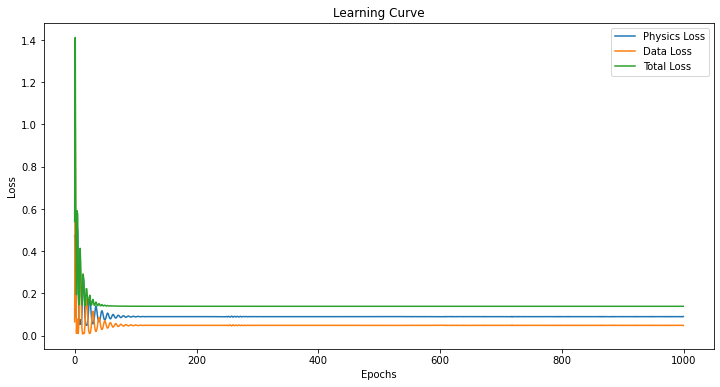

In [176]:
# Plot the learning curve
plt.figure(figsize=(12, 6))
plt.plot(physics_losses, label='Physics Loss')
plt.plot(data_losses, label='Data Loss')
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [188]:
#Make predictions on the training data
y_train_pred = model(X_train)
MSE = mean_squared_error(y_train, y_train_pred)
RMSE= np.sqrt(mean_squared_error(y_train, y_train_pred))
MAE = mean_absolute_error(y_train, y_train_pred)

print(f"Training Mean Squared Error: {MSE}")
print(f"Training Root Mean Squared Error: {RMSE}")
print(f" Training Mean Absolute Error: {MAE}")

Training Mean Squared Error: 0.04952121898531914
Training Root Mean Squared Error: 0.22253362834453583
 Training Mean Absolute Error: 0.20832672715187073


In [190]:
# Evaluate the model on test data
y_pred = model(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test Root Mean Squared Error: {rmse}")
print(f"Test Mean Absolute Error: {mae}")

Test Mean Squared Error: 0.05107932165265083
Test Root Mean Squared Error: 0.226007342338562
Test Mean Absolute Error: 0.21190708875656128
